## IMDB Sentiment analysis with google Word2vec
In this notebook, we will implement a neural network to do sentiment analysis on the IMDB movie comments using a pre-trained Word2Vec. We will also use a generator in order to spare some memory during training.

In [1]:
import time
import os
import pandas as pd
import re
from sklearn.utils import shuffle
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalMaxPooling1D

In [3]:
from gensim import models
from nltk.tokenize import TreebankWordTokenizer
from nlpia.loaders import get_data

C:\Users\cthew\anaconda3\envs\movie_reviews_3.6\lib\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
INFO:nlpia.constants:Starting logger in nlpia.constants...
INFO:nlpia.loaders:No BIGDATA index found in C:\Users\cthew\anaconda3\envs\movie_reviews_3.6\lib\site-packages\nlpia\data\bigdata_info.csv so copy C:\Users\cthew\anaconda3\envs\movie_reviews_3.6\lib\site-packages\nlpia\data\bigdata_info.latest.csv to C:\Users\cthew\anaconda3\envs\movie_reviews_3.6\lib\site-packages\nlpia\data\bigdata_info.csv if you want to "freeze" it.
INFO:nlpia.futil:Reading CSV with `read_csv(*('C:\\Users\\cthew\\anaconda3\\envs\\movie_reviews_3.6\\lib\\site-packages\\nlpia\\data\\mavis-batey-greetings.csv',), **{'low_memory': False})`...
INFO:nlpia.futil:Reading CSV with `read_csv(*('C:\\Users\\cthew\\ana

In [4]:
train_urls_neg = pd.read_csv('./data/aclImdb/train/urls_neg.txt', sep='\t',names=["imdb_urls"])
train_urls_pos = pd.read_csv('./data/aclImdb/train/urls_pos.txt', sep='\t',names=["imdb_urls"])
test_urls_neg = pd.read_csv('./data/aclImdb/test/urls_neg.txt', sep='\t',names=["imdb_urls"])
test_urls_pos = pd.read_csv('./data/aclImdb/test/urls_pos.txt', sep='\t',names=["imdb_urls"])
name_basics_iterator = pd.read_csv('./data/name_basics/data.tsv', sep='\t',chunksize=100000)

This cell handles the recuperation of the file who contains the comment. We will also link the comment to the movies in case we need any information later about the movie.

In [5]:
regex_id_files = '^\d+'
regex_id_titles = 't{2}\d+'
directory_data=["./data/aclImdb/train/","./data/aclImdb/test/"]
list_title_comment_eval_train=[]
list_title_comment_eval_test=[]
directory_data_split=['neg','pos']
#Retrieves the data scattered into the differents directories. 
for dir_data_path in directory_data:
    for name_directory in directory_data_split:
        with os.scandir(dir_data_path+name_directory) as files:
            for file in files:
                try:
                    id_file = re.search(regex_id_files, file.name).group()
                    movie_url=train_urls_neg.iloc[int(id_file)].imdb_urls
                    id_title = re.search(regex_id_titles, movie_url).group()
                    f = open(file, "r", encoding="utf8")
                    review = f.read()
                    if "train" in dir_data_path:
                        list_title_comment_eval_train.append([id_title,name_directory,review])
                    else:
                        list_title_comment_eval_test.append([id_title,name_directory,review])
                except AttributeError:
                    print("Error regex should have been found")

In [6]:
train_df=pd.DataFrame(list_title_comment_eval_train, columns=["id_title", "sentiment", "reviews"])
test_df=pd.DataFrame(list_title_comment_eval_test, columns=["id_title", "sentiment", "reviews"])

In [7]:
if not os.path.exists('./dataset'):
    os.makedirs('./dataset')
train_df.to_pickle("./dataset/train_df.pkl")
test_df.to_pickle("./dataset/test_df.pkl")

In [8]:
#Loading the dataset 
train_df=pd.read_pickle("./dataset/train_df.pkl")
test_df=pd.read_pickle("./dataset/test_df.pkl")

In [9]:
#Shuffle the row of our dataset. 
#Our target his balanced and is equally represented in the test and in the train
dataset_df=[shuffle(train_df),shuffle(test_df)]

In [10]:
#we change the categorical varaibles into numerical (Dummy)
for dataframe in dataset_df:
    dataframe["sentiment"]=dataframe["sentiment"].replace({'neg':0,'pos':1})

In order to tokenize and vectorize the data. We will use the Google New pretrained word2vec.

In [11]:
#Unpacking the vectors with gensim
word_vectors = models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True, limit=100000)

INFO:gensim.models.utils_any2vec:loading projection weights from ./GoogleNews-vectors-negative300.bin
INFO:gensim.models.utils_any2vec:loaded (100000, 300) matrix from ./GoogleNews-vectors-negative300.bin


In [12]:
maxlen = 400
dataset_size=train_df.shape[0]
batch_size = 32
embedding_dims = 300
steps_per_epoch = dataset_size // batch_size

In [13]:
def preprocessing(dataset, chunk_size = batch_size):
    """ 
    We use a function who yields generators to spare some memory during execution.  
    All the step for the preprocessing has been gathered into this function.
    So the first step is to tokenized and vectorized. The second is to give to each vector the same dimension. 
    ------
    dataset : (PandasDataFrame) the imdb data which need to be preprocess 

    chunk_size : Size of the yields batch who would be given to the model. 
                 The default value is set by the variable batch_size

    Returns
    -------     
    batch_x : (Generator) the result of preprocessing on reviews, inputs used to do the prediction. 
    batch_y : (Generator) the target of the training
    """
    tokenizer = TreebankWordTokenizer()
    num_chunks = len(dataset) // chunk_size + 1
    zero_vector = []
    # This would be the vector that we had if the review is too short
    # The value of 300 has been defined by the average length of a review tokenized
    for _ in range(300):
        zero_vector.append(0.0)
    while True: #Loop forever so the generator never terminates
        for i in range(num_chunks):
            if dataset[i*chunk_size:(i+1)*chunk_size].shape[0]!=0:
                batch_x = []
                batch_y = []
                for index, row in dataset[i*chunk_size:(i+1)*chunk_size].iterrows():
                    tokens = tokenizer.tokenize(row["reviews"])
                    word_vectors_list = []
                    #tokenize the data and then create a list of the vectors for those tokens
                    for token in tokens:
                        try:
                            word_vectors_list.append(word_vectors[token].tolist())
                        except KeyError:
                            pass 
                    #Each input to a convolutional network must be equal in dimension.
                    #So we have to define a maximum review length by maxlen.
                    #You truncate any samples that is longer than maxlen and fill the one that are shorter with 0.
                    if len(word_vectors_list) > maxlen:
                        tmp = word_vectors_list[:maxlen]
                    elif len(word_vectors_list) < maxlen:
                        tmp = word_vectors_list
                        additional_elems = maxlen - len(word_vectors_list)
                        for _ in range(additional_elems):
                            tmp.append(zero_vector)
                    else:
                        tmp = word_vectors_list
                    batch_x.append(tmp)
                    batch_y.append(row["sentiment"])
                batch_x = np.reshape(batch_x, (len(batch_x), maxlen, embedding_dims))   
                batch_y = np.array(batch_y) 
                yield batch_x, batch_y

In [14]:
vectorize_dataset=[]
for dataframe in dataset_df:
    vectorize_dataset.append(preprocessing(dataframe))

In [15]:
train_generator=vectorize_dataset[0]
test_generator=vectorize_dataset[1]

In [16]:
model = Sequential()
model.add(Conv1D(
    250,
    3,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(maxlen, embedding_dims)))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [17]:
history=model.fit(train_generator, verbose=1, steps_per_epoch=steps_per_epoch,epochs=10, validation_data=test_generator,
validation_steps=steps_per_epoch)

Epoch 1/10
781/781 [==============================] - 291s 372ms/step - loss: 0.4669 - accuracy: 0.7651 - val_loss: 0.3313 - val_accuracy: 0.8547A: 37s - loss: 0.4921 - ac - ETA: 34s - loss: 0.4899 - - ETA: 31s - loss: 0.4874 - accuracy: 0.750 - ETA: 31s - loss: 0.4873 -  - ETA: 1s - loss: 0.4678 - 
Epoch 2/10
781/781 [==============================] - 297s 380ms/step - loss: 0.2555 - accuracy: 0.8977 - val_loss: 0.3086 - val_accuracy: 0.8750- - ETA: 37s - loss: 0.2616 - accurac - ETA: 35s - loss: 0.2613 -  - ETA: 32s - loss: 0.2607 - accurac - ETA: 30s - 
Epoch 3/10
781/781 [==============================] - 297s 381ms/step - loss: 0.1475 - accuracy: 0.9486 - val_loss: 0.3654 - val_accuracy: 0.8812loss: 0.1562 - accuracy:  - ETA: 46s - loss: 0.1559 - accur - ETA: 44s - los - ETA: 39s - loss: 0.1543 - accuracy: 0.946 - ETA: 38s - loss: 0.1542 - accuracy: - ETA: 37s - loss: 0.1540 - accura - ETA: 26s - loss: 0.1519 - accuracy: 0.9 - ETA: 25s - los - ETA: 20s - loss: 0.1508 - accur - ETA

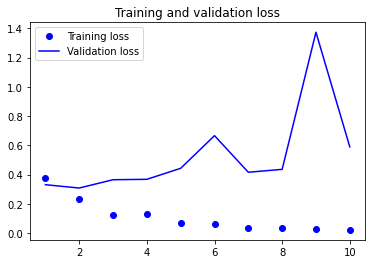

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

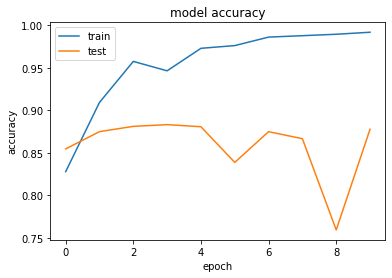

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
#Saving the model
model_structure = model.to_json()
with open("IMDB_1D_CNN.json", "w") as json_file:
    json_file.write(model_structure)

In [21]:
#Saving the weights
model.save_weights("IMDB_1D_CNN_Weights.h5")